# Расчёт амплитуд в 2.5D: опасные моменты.
## Часть 1: когда всё плохо

На данный момент расчёт лучевых амплитуд производится в том числе при решении 2.5D-задачи. Мне кажется, это не вполне корректно. Расчёт лучевой амплитуды в моём понимании относится к этапу получения синтетических данных, т.е. получаемые величины должны быть как можно ближе к действительности.

В этом ноутбуке будет показано, как изменяются синтетические амплитуды, если их считать в 2.5-мерном приближении. <b>Рассмотрен случай, когда реальные лучевые схемы не являются двумерными.<b/>
<hr>

# Модель, в которой лучевые схемы не являются двумерными

Импортируем необходимые модули:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Импортируем главные компоненты для лучевого моделирования
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
from src import tprt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Созадим модель, состоящую из трёх слоёв. Первая граница будет плоской полого падающей в направлении y = x. Вторая - криволинейным желобом, вытянутым в направлении y = - x.

In [17]:
v_1 = tprt.ISOVelocity(vp=2000.0, vs=1000.0)
rho_1 = 2300.0

v_2 = tprt.ISOVelocity(vp=2500.0, vs=1250.0)
rho_2 = 2400.0

v_3 = tprt.ISOVelocity(vp=3000.0, vs=1500.0)
rho_3 = 2500.0

In [18]:
hor_1 = tprt.FlatHorizon(depth=200.0, anchor=np.array([0, 0]), 
                         dip=10.0, azimuth=45.0, 
                         region=np.array([[- 1000, - 1000], [1000, 1000]]))

In [19]:
x_set = np.linspace(- 1000, 1000, 1001)
y_set = np.linspace(- 1000, 1000, 1001)

yy_set, xx_set = np.meshgrid(y_set, x_set)

z_set = 500.0 + 100 * np.exp(- (yy_set + xx_set)**2 / 250000)

hor_2 = tprt.GridHorizon(x_set=x_set, y_set=y_set, z_set=z_set, bool_parab=False)

Соберём и нарисуем модель:

In [20]:
model = tprt.VelocityModel(velocity = np.array([v_1, v_2, v_3]),
                           density = np.array([rho_1, rho_2, rho_3]),
                           name = np.array(['1', '2', '3']),                      
                           horizons = [hor_1, hor_2])

<IPython.core.display.Javascript object>


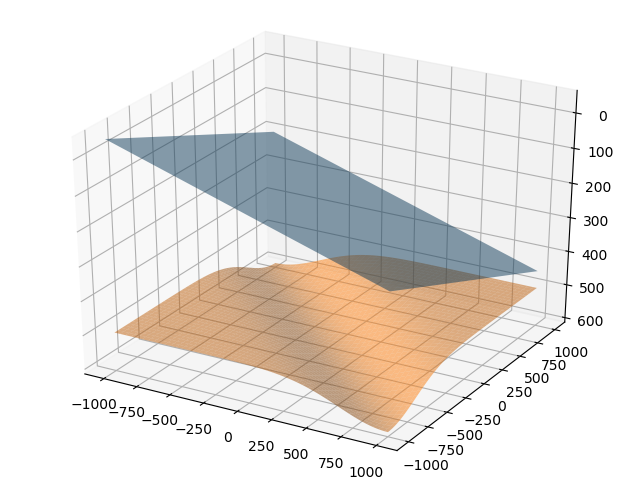

In [21]:
%matplotlib notebook
# нужно чтобы можно было вертеть трехмерную картинку

fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

model.plot(ax=ax)

<hr>

# Схема наблюдений

Источник:

In [22]:
source_freq = 25.0
source_location = np.array([0, 0, 0], dtype=float)

In [23]:
source = tprt.DilatCenter(model, source_freq, source_location)

Создадим профиль приёмников, вытянутый вдоль оси X:

In [24]:
# Все приемники будут трехкомпонентные с одинаковой ориентацией
orientation = np.array([
    [1, 0, 0],  # axis x
    [0, -1, 0], # axis y
    [0, 0, -1]  # axis z
])

# Профиль приемников
rec_loc_x = np.arange(-800, 825, 25)
receivers_profile = np.empty(rec_loc_x.shape, dtype=tprt.Receiver)
for i, _x in enumerate(rec_loc_x):
    receivers_profile[i] = tprt.Receiver([_x, 0.0, 0.0], orientation=orientation)

Лучевые схемы не будут двумерными; неправильный учёт кривизны границ также скажется на лучевых амплитудах. Чтобы показать это, создадим две одинаковые схемы наблюдений. Для одной будем производить расчёты в 3D, а для другой - в 2D.

In [25]:
survey_profile_3d = tprt.Survey(source, receivers_profile, model)
survey_profile_2d = tprt.Survey(source, receivers_profile, model)

In [32]:
rec_loc_x[central_num]

0

<hr>

## Лучевые схемы

<IPython.core.display.Javascript object>


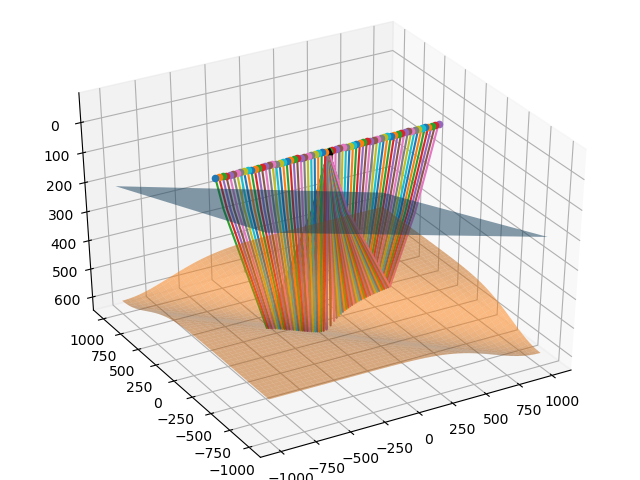

In [26]:
# Лучи строятся в 3D
survey_profile_3d.initialize_rays(reflect_horizon=2, vtype='vp', forward=False)
survey_profile_3d.calculate(method='bfgs', survey2D=False)

fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

model.plot(ax=ax)
survey_profile_3d.plot(ax=ax)

<IPython.core.display.Javascript object>


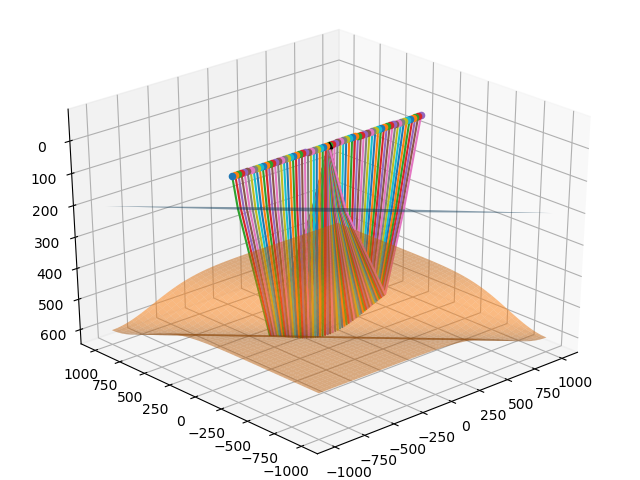

In [27]:
# Лучи строятся в 2D
survey_profile_2d.initialize_rays(reflect_horizon=2, vtype='vp', forward=False)
survey_profile_2d.calculate(method='bfgs', survey2D=True)

fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

model.plot(ax=ax)
survey_profile_2d.plot(ax=ax)

<hr>

## Лучевые амплитуды 

Построим графики лучевых амплитуд (модулей) вдоль схем наблюдений:

<IPython.core.display.Javascript object>


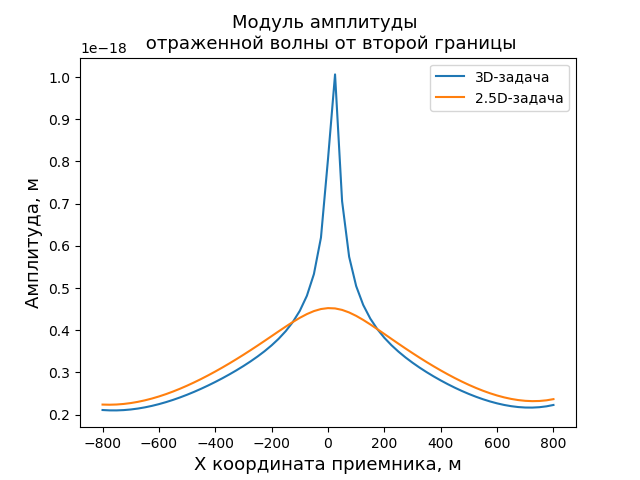

In [28]:
fontsize=13

plt.figure()
plt.title('Модуль амплитуды \n отраженной волны от второй границы', fontsize=fontsize)

plt.xlabel('X координата приемника, м', fontsize=fontsize)
plt.ylabel('Амплитуда, м', fontsize=fontsize)

plt.plot(rec_loc_x, np.linalg.norm(survey_profile_3d.amplitudes, axis=2)[0], label="3D-задача")
plt.plot(rec_loc_x, np.linalg.norm(survey_profile_2d.amplitudes, axis=2)[0], label="2.5D-задача")

plt.legend()

plt.show()

Видно, что по модулю различия быстро сглаживаются. Однако, относительное изменение амплитуды вдоль профиля в 2.5D сильно отличается от 3D:

<IPython.core.display.Javascript object>


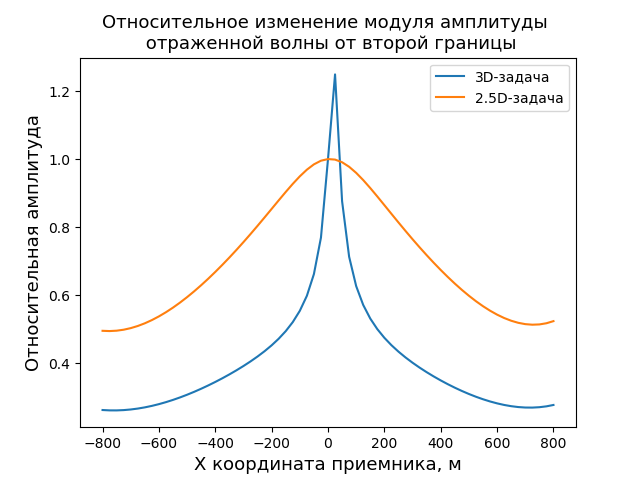

In [34]:
fontsize=13

central_num = len(rec_loc_x) // 2

plt.figure()
plt.title('Относительное изменение модуля амплитуды \n отраженной волны от второй границы', fontsize=fontsize)

plt.xlabel('X координата приемника, м', fontsize=fontsize)
plt.ylabel('Относительная амплитуда', fontsize=fontsize)

plt.plot(rec_loc_x, np.linalg.norm(survey_profile_3d.amplitudes, axis=2)[0] /
         np.linalg.norm(survey_profile_3d.amplitudes, axis=2)[0, central_num], label="3D-задача")
plt.plot(rec_loc_x, np.linalg.norm(survey_profile_2d.amplitudes, axis=2)[0] /
         np.linalg.norm(survey_profile_2d.amplitudes, axis=2)[0, central_num], label="2.5D-задача")

plt.legend()

plt.show()